# Orientation Selectivity emerges in the feedforward pathway from random sampling the visual field

By [Wenqing Wei](mailto://wenqing.wei@bcf.uni-freiburg.de)

<a href="https://www.biorxiv.org/content/10.1101/2022.07.18.500396v1"> A theory of orientation selectivity emerging from randomly sampling the visual field<a>

In [1]:
# Import modules
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt; plt.ion()
import random
import math
import time

In [2]:
# Plotting modules
import matplotlib.cm as cm
from matplotlib import gridspec
import matplotlib.colors as colors
from matplotlib.font_manager import FontProperties
import matplotlib.collections
import os

## __Task 1:__ The OS emerges in the thalamic input from random sampling the visual field

<font size="3">In the visual pathway, following light transduction in the retina, signals are mostly conveyed to the dorsal latefal geniculate nucleus (dLGN) of the thalamus and further relayed to V1. In mammals, most neurons in the primary visual cortex (V1) respond selectively to the orientation of lines, bars or edges. This phenomenon is call orientation selectivity (OS). In the feedforward model proposed by Hubel and Wiesel (1962), the receptive fields (RF) of dLGN neurons in the thalamus converging to a V1 neuron would be aligned along an axis to generate the elongated RF of the V1 neuron. 
<img src="./NEST_tutorial_OSemergence/NEST_JupyterNotebook/example/Hubel&Wiesel_1962.png" alt="RF alignment" width="450" align="center"/>
    
<font size="3">However, this model requires a mechanism to establish the specific arrangement of RFs during development, possibly driven by visual experience. Therefore, we proposed an alternative mechanism that does not depend on precisely arranged thalamocortical projections and OS can emerge. <br></font>
    
In this task, you will observe/plot out:
1. The RF of dLGN neurons are modeled as 2D Difference-of-Gaussian (DOG) model.
2. Random sampling the visual field.
3. The thalamic inputs, which is a linear sum of the responses of all presynaptic dLGN neurons, indeed tune to the stimulus orientations.

### __Task 1.1__: The dLGN neurons have circular center-surround RFs and are modeled as DOG model.

\begin{equation}
    \mathrm{RF} (x, y) = \frac{1}{2\pi \sigma_{+}^{2}}\cdot e^{-\frac{(x - \mu_x)^2 + (y-\mu_y)^2}{2\sigma_{+}^{2}}} - \frac{1}{2\pi \sigma_{-}^{2}}\cdot e^{-\frac{(x - \mu_x)^2 + (y-\mu_y)^2}{2\sigma_{-}^{2}}}
\end{equation}
 where $(\mu_x, \mu_y)$ denotes the position of the receptive field center of RGCs. 

In [3]:
def receptive_field(x, sigma_pl, sigma_mi, mu, c):
    ''' The receptive field is modeled as the difference of two Gaussians; 
    Theoretically the range of x is from minus infinite to infinite in the space (not time).
    sigma_pl: the sigma of the center.
    sigma_mi: the sigma of the surround.'''
    rf_p = np.exp(-(x-mu)**2/(2 * sigma_pl**2)) / (2 * np.pi * sigma_pl**2)**0.5
    rf_m = np.exp(-(x-mu)**2/(2 * sigma_mi**2)) / (2 * np.pi * sigma_mi**2)**0.5
    rf = rf_p - c * rf_m
    return rf, rf_p, rf_m

######################################################################3
# plotting functions

def plot_receptive_field(x, sigc=1., sigs=5.):

    rf, rf_p, rf_m = receptive_field(x, sigc, sigs, 0., 1.)
    
    plt.plot(x, rf_p/np.max(rf), linewidth=2., color='mediumslateblue', linestyle='--', alpha=1)
    plt.plot(x, -rf_m/np.max(rf), linewidth=2., color='lightpink', linestyle='--', alpha=1)
    plt.plot(x, rf/np.max(rf), linewidth=2., color='k')
    
    plt.xlabel(r'Spatial position $[^\circ]$')
    plt.ylabel('Neuronal response')


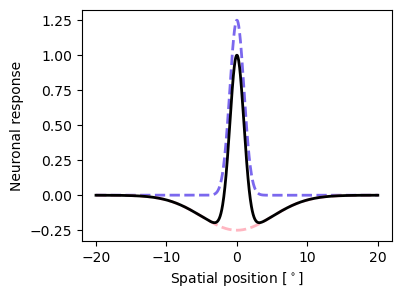

In [4]:
# Now plot out the RF of an dLGN neuron
plt.rcParams['figure.figsize'] = [4, 3]
sigc, sigs = 1., 5. 
x = np.linspace(-20., 20, 1000)

plot_receptive_field(x, sigc=sigc, sigs=sigs)

# change the values of sigc and sigs

<font size="3"> In order to study the OS, sinusoidala drifting gratings are used for visual stimulation. Shown is an example of a grating at 60$^\circ$. The variables of the grating are the spatial frequency and the temporal frequency. <br></font>
<img src="NEST_tutorial_OSemergence/NEST_JupyterNotebook/example/single_Grating_60.gif" width="350" align="center">


In [5]:
# plotting functions of the moving grating at a fixed time point.
lw = 2.
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    
    return new_cmap

def points_over_grating(vf, Fre_spa, Fre_tem, theta):
    t = 0.1
    sf = (2. * np.pi) * Fre_spa
    k = sf * np.array([np.sin(theta), np.cos(theta)]).reshape((2,1))
    
    vf_range = np.arange(-vf/2., vf/2. + 0.1, 0.1)
    Xs, Ys = np.meshgrid(vf_range, vf_range)
    x = np.concatenate((Xs.reshape((-1,1)), Ys.reshape((-1,1))), axis = 1)
    F = 1 + np.cos(np.dot(x, k) - 2 * np.pi * Fre_tem * t)
    F = F.reshape((vf_range.size, vf_range.size))
    return vf_range, vf_range, F

def plot_grating(ax, vf, Fre_spa, Fre_tem, theta, plot_rf = False, ON_point=None, OFF_point=None):
    '''
    fig = plt.figure(title)
    gs = gridspec.GridSpec(1,1)
    ax0 = plt.subplot(gs[0])
    '''
    
    na, nb, nFr = points_over_grating(vf, Fre_spa, Fre_tem, theta)
    v = np.array([0., 1., 2.])
    cmap = plt.get_cmap('gray')
    #new_cmap = truncate_colormap(cmap)
    new_cmap = matplotlib.colors.ListedColormap(cmap(np.linspace(0.5, 1, 128)))
    im = plt.imshow(nFr/2., interpolation = 'bilinear', cmap = new_cmap, extent = [np.amin(na), np.amax(na), np.amin(nb), np.amax(nb)])
    cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)#, ticks = v)
    cb.set_label('Light intensity (a.u.)')
    #cb.ax.tick_params(labelsize = 20)
    circle = plt.Circle((0.,0.), vf/2., color = 'black', fill = False, linewidth = lw)
    plt.gcf().gca().add_artist(circle)
    ax.set_xlim(np.amin(na), np.amax(na))
    ax.set_ylim(np.amin(nb), np.amax(nb))
    ax.set_xlabel(r'X($^\circ$)')
    ax.set_ylabel(r'Y($^\circ$)')
    
    if plot_rf == True:
        size = 2
        if ON_point is None:
            print ('No ON center cell!')
        else:
            ONpatches = [plt.Circle(center, size, fill=False) for center in ON_point]
            ONcoll = matplotlib.collections.PatchCollection(ONpatches, facecolor='brown', edgecolors='none', linewidth=lw)
            ax.add_collection(ONcoll)
        if OFF_point is None:
            print ('No OFF center cell!')
        else:
            OFFpatches = [plt.Circle(center, size, fill=False) for center in OFF_point]
            OFFcoll = matplotlib.collections.PatchCollection(OFFpatches, facecolor='green', edgecolors='none', linewidth=lw)
            ax.add_collection(OFFcoll)



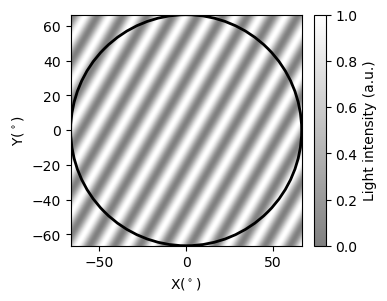

In [6]:
# Now you can plot out the stimulus with any parameters you like

# assigning parameters to variables
vf = 133.
rf = 28.
Fre_spa = 0.08
Fre_tem = 3.
sigc, sigs = 1., 5.
theta = np.pi/3.

ax = plt.subplot()
plot_grating(ax,vf, Fre_spa, Fre_tem, theta)

The firing rate of a dLGN neuron in response to a visual stimuli is the integration of its RF and light intensity of the stimuli over space.

 \begin{equation} \label{eq:inst_rate}
     \nu_i(t) = \nu_b + \iint \mathrm{RF}(x, y) S(x, y, t) dx dy .
 \end{equation}
 
The temporal firing rate of a dLGN neuron in response to a sinusoidal moving grating will be sinusoidally modulated. The phase depend on its position on the visual field and the amplitude depends on its RF variables and the spatial frequency of the grating. Detailed explanation can be found in <a href="https://www.biorxiv.org/content/10.1101/2022.07.18.500396v1">here<a>.

In [7]:
# Functions to calculate the temporal firing rate of a dLGN neuron in repsonse to a moving grating.
def optimal_sf(sigc, sigs):
    '''calculate the optimal spatial frequency which gives the maximum value of m with (sigc, sigs) of the DoG model.'''
    sf = 2 * np.sqrt(np.log(sigs/sigc)/(sigs**2 - sigc**2))
    Fre_spa = sf/(2 * np.pi)
    return Fre_spa

def m_max(sigc, sigs):
    '''calculate the maximum value of m.'''
    Fre_spa = optimal_sf(sigc, sigs)
    sf = 2 * np.pi * Fre_spa
    m = np.exp(-sf**2 * sigc**2 / 2.) - np.exp(-sf**2 * sigs**2 / 2.)
    return m

def single_LGN_response_curve(mu, theta, Fre_spa, Fre_tem, sigc, sigs, t):
    '''The equation is to calculate the temporal response curve of a dLGN cell when the moving grating is presented.
    Parameters:
    mu: the position of the receptive field of the dLGN cell;
    theta: stimulus orientation of the moving grating;
    Fre_spa: spatial frequency, unit in cycles per degree (cpd);
    Fre_tem: temporal frequency, unit in Hz.'''
    sf = 2 * np.pi * Fre_spa
    m = np.exp(-sf**2 * sigc**2 / 2.) - 1 * np.exp(-sf**2 * sigs**2 / 2.)
    mmax = m_max(min(sigc, sigs), max(sigc, sigs))
    kv = sf * np.array([np.sin(theta), -np.cos(theta)]).reshape((2, 1))
    rt = mmax + m * np.cos(2*np.pi*Fre_tem*t - np.dot(mu, kv))
    return rt

No OFF center cell!


Text(0, 0.5, 'rate')

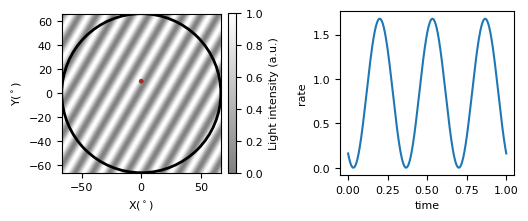

In [8]:
# Now you can visualise the temporal response of a dLGN neuron whose RF center is at mu.

t = np.linspace(0., 1., 1000)
mu = np.array([[0., 10.]])
# assume that mu is the position of an ON-center cell
rt = single_LGN_response_curve(mu, theta, Fre_spa, Fre_tem, sigc, sigs, t)

dpi = 300
width = 5.2
height = 0.45*width
fgsz = (width, height)
plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=fgsz)
gs = gridspec.GridSpec(1, 2, left=0.1, right=0.97, wspace=.6, bottom=0.2, top=0.9)
ax00 = plt.subplot(gs[0,0])
plot_grating(ax00, vf, Fre_spa, Fre_tem, theta, plot_rf=True, ON_point=mu)
ax01 = plt.subplot(gs[0,1])
ax01.plot(t, rt[0])
ax01.set_xlabel('time')
ax01.set_ylabel('rate')


### __Task 1.2__: Random sampling the visual field

In [9]:
def get_random_points(n, vf):
    ''' get random positions within the visual field.
    n: the number of positions.
    vf: the diameter of the visual field.'''
    nps = np.empty((n, 2))
    for i in range(n):
        r = vf/2. * math.sqrt(random.random())
        alpha = 2 * np.pi * random.random()
        x = r * np.cos(alpha)
        y = r * np.sin(alpha)
        nps[i,0] = x
        nps[i,1] = y
    return nps

def nearest_idx(nps, single_V1, nn):
    ''' get the nn nearest indices of LGN neurons to a single V1 neuron.'''
    #distance = np.linalg.norm(nps - single_V1.reshape((1,2)), axis = 1)
    c = nps - single_V1.reshape((1,2))
    distance = np.sqrt(np.einsum('ij, ij->i', c, c))
    nearest_id = distance.argsort()[:nn]
    return nearest_id

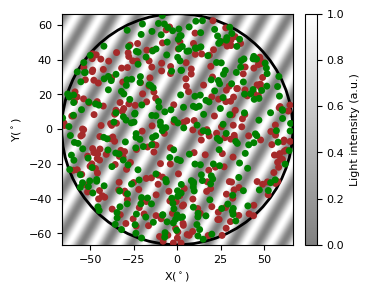

In [10]:
# Random sampling the visual field
n = 3000
nps = get_random_points(n, vf)

nps_ON = nps[:int(n/2)]  # ON center cells
nps_OFF = nps[int(n/2):]  # OFF center cells

# plot 20% of them on the visual field
ax = plt.subplot()
plot_grating(ax,vf, Fre_spa, Fre_tem, theta, plot_rf = True, ON_point=nps_ON[::5], OFF_point=nps_OFF[::5])

A single V1 neuron receives inputs from the nearest N dLGN neurons.<a id='dLGN_inputs'></a>

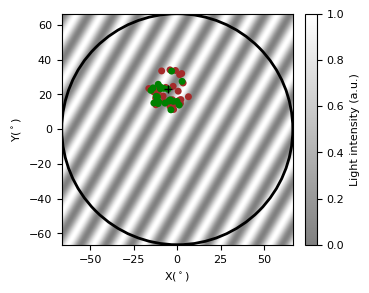

In [11]:
# The positions of the RFs of the presynaptic dLGN neurons are also random.
V1_loc = get_random_points(1, vf-rf/2)
N = 100

input_id = nearest_idx(nps, V1_loc, N)

ONids = input_id[input_id < int(n/2)]
OFFids = input_id[input_id >= int(n/2)]

nps_ONinput = nps[ONids]
nps_OFFinput = nps[OFFids]

ax = plt.subplot()
plot_grating(ax,vf, Fre_spa, Fre_tem, theta, plot_rf = True, ON_point=nps_ONinput[::2], OFF_point=nps_OFFinput[::2])
ax.plot(V1_loc[0, 0], V1_loc[0, 1], 'k+')

### __Task 1.3__: The amplitudes of the compound thalamic input tune to the stimulus orientations, while the means remain identical

In [12]:
# The compound thalamic input is a linear sum of the responses of all presynaptic dLGN neurons.

def compound_LGN_temporal_response(theta, Fre_spa, Fre_tem, sigc, sigs, t, nps_ON=None, nps_OFF=None):
    '''nps_ON and nps_OFF should be in the shape of ((n, 2)), n is the number of respective nodes.'''
    sum_sig = np.zeros((len(t)))
    if nps_ON is None:
        print ('No ON center cell!')
    else:
        for i in range(len(nps_ON)):
            rt = single_LGN_response_curve(nps_ON[i], theta, Fre_spa, Fre_tem, sigc, sigs, t)
            sum_sig += rt
    if nps_OFF is None:
        print ('No OFF center cell!')
    else:
        for j in range(len(nps_OFF)):
            rt = single_LGN_response_curve(nps_OFF[j], theta, Fre_spa, Fre_tem, sigs, sigc, t)
            sum_sig += rt
    return sum_sig

stimulus orientation: 0; mean: 83.94; amplitude: 13.37
stimulus orientation: 60; mean: 83.95; amplitude: 5.02
stimulus orientation: 120; mean: 83.95; amplitude: 2.73


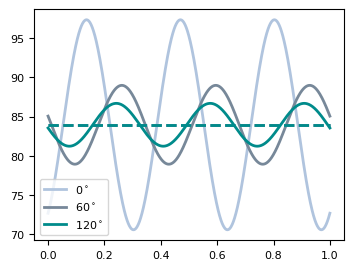

In [13]:
# plot out the temporal response curves of the thalamic inputs at different stimulus orientations
plot_degrees = np.array([0, 60, 120])
color_codes = ['lightsteelblue', 'lightslategrey', 'darkcyan']
for i in range(len(plot_degrees)):
    theta = plot_degrees[i]*np.pi/180.
    response = compound_LGN_temporal_response(theta, Fre_spa, Fre_tem, sigc, sigs, t, 
                                              nps_ON=nps_ONinput,nps_OFF=nps_OFFinput)
    plt.plot(t, response, linewidth=2., color = color_codes[i], label=str(plot_degrees[i])+r'$^\circ$')
    plt.plot(t, np.ones((len(t)))*np.mean(response), color=color_codes[i], linestyle='--', linewidth=2)
    
    mean, amplitude = np.mean(response), np.max(response) - np.mean(response)
    print ('stimulus orientation: %i; mean: %.2f; amplitude: %.2f'%(plot_degrees[i], mean, amplitude))

plt.legend()

In [14]:
################################################################################
# This section of the code implements the Eq. 18 in our paper to calculate 
# the analytical result of the amplitude of the compound thalamic inputs to V1 neurons.
################################################################################

def get_alphas(nps, theta, Fre_spa):
    ''' calculate alphas and cosine of differences of alphas. '''
    sf = 2 * np.pi * Fre_spa
    k = sf * np.array([np.sin(theta), -np.cos(theta)]).reshape((2, 1))
    alpha = np.dot(nps, k)
    diff_alpha = []
    for i in range(len(alpha) - 1):
        diff_alpha.append(alpha[i] - alpha[i + 1::])
    diff = np.concatenate(diff_alpha, axis = 0)
    cos_diff = np.cos(diff)
    return alpha, cos_diff

def compound_amplitude_phase(nps, Fre_spa, sigc, sigs, theta, A=1):
    ''' calculate the amplitude and phase of the compound signal of the group of LGN neurons. '''
    sf = 2 * np.pi * Fre_spa
    m = np.exp(-sf**2 * sigc**2 / 2.) - 1 * np.exp(-sf**2 * sigs**2 / 2.)    
    if len(nps)==1:
        amplitude = m*A
        k = k_vector(Fre_spa, theta)
        phase = np.dot(nps, k)
    
    if len(nps)==0:
        amplitude, phase = 0,0


    if len(nps)>=2:
        alpha, cos_diff = get_alphas(nps, theta, Fre_spa)
        amplitude = m * A * np.sqrt(len(nps) + 2 * np.sum(cos_diff))
        x = np.sum(np.cos(alpha))
        y = np.sum(np.sin(alpha))
        if x < 0:
            phase = np.arctan(y/x) + np.pi
        else:
            phase = np.arctan(y/x)

    return amplitude, phase

def sep_compound_amplitude_phase(nps_ON, nps_OFF, Fre_spa, sigc, sigs, theta, A=1):
    ''' calculate the amplitude and phase of the compound signal including excitatory and inhibitory group. '''

    amp_ON, phase_ON = compound_amplitude_phase(nps_ON, Fre_spa, sigc, sigs, theta)
    amp_OFF, phase_OFF = compound_amplitude_phase(nps_OFF, Fre_spa, sigs, sigc, theta)
        
    sep_amp = np.sqrt(amp_ON ** 2 + amp_OFF ** 2 + 2 * amp_ON * amp_OFF * np.cos(phase_ON - phase_OFF))
    
    x = amp_ON * np.cos(phase_ON) + amp_OFF * np.cos(phase_OFF)
    y = amp_ON * np.sin(phase_ON) + amp_OFF * np.sin(phase_OFF)
    
    if x < 0:
        sep_phase = np.arctan(y/x) + np.pi
    else:
        sep_phase = np.arctan(y/x)

    return sep_amp, sep_phase



In [15]:
# Now compare the analytical solution with the numerical sum.
for i in range(len(plot_degrees)):
    theta = plot_degrees[i]*np.pi/180.
    sep_amp, sep_phase = sep_compound_amplitude_phase(nps_ONinput, nps_OFFinput, Fre_spa, sigc, sigs, theta)
    print ('stimulus orientation: %i; amplitude: %.2f'%(plot_degrees[i], sep_amp))

stimulus orientation: 0; amplitude: 13.36
stimulus orientation: 60; amplitude: 5.02
stimulus orientation: 120; amplitude: 2.73


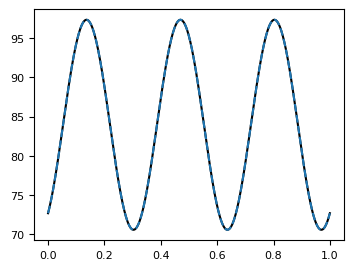

In [16]:
# small test: try to recover the temporal response curve from the analytical amplitude and phase
# and compare them to the linear summation of all presynaptic responses.

theta = plot_degrees[0] * np.pi/180.
sep_amp, sep_phase = sep_compound_amplitude_phase(nps_ONinput, nps_OFFinput, Fre_spa, sigc, sigs, theta)
mmax = m_max(min(sigc, sigs), max(sigc, sigs))
mean = mmax * 100.
plt.plot(t, mean + sep_amp*np.cos(2*np.pi*Fre_tem*t - sep_phase), 'k')

response = compound_LGN_temporal_response(theta, Fre_spa, Fre_tem, sigc, sigs, t, 
                                              nps_ON=nps_ONinput,nps_OFF=nps_OFFinput)
plt.plot(t, response, '--')


In [17]:
# Now generate 2500 random V1 neurons on the visual field.
V1_locs = get_random_points(2500, vf-rf/2.)

# Stimulate the network with sinusoidal gratings at 12 orientations evenly cover [0, 180) degrees
degrees = np.arange(0., 180., 15)

# calculate the amplitudes and phases of the compound thalamic inputs to all V1 neurons.
amplitudes = np.empty((len(V1_locs), len(degrees)))
phases = np.empty((len(V1_locs), len(degrees)))
t0 = time.time()
for i in range(len(V1_locs)):
    input_id = nearest_idx(nps, V1_locs[i], N)

    ONids = input_id[input_id < int(n/2)]
    OFFids = input_id[input_id >= int(n/2)]

    nps_ONinput = nps[ONids]
    nps_OFFinput = nps[OFFids]
    for di in range(len(degrees)):
        theta = degrees[di]*np.pi/180.
        amp, phase = sep_compound_amplitude_phase(nps_ONinput, nps_OFFinput, Fre_spa, sigc, sigs, theta)
        amplitudes[i, di] = amp
        phases[i, di] = phase
print (time.time() - t0)

10.96659517288208


## __Task 2:__ Network simulation: whether the orientation bias in the input amplitude can be transformed into the output orientation tuning?

In our [work](https://www.biorxiv.org/content/10.1101/2022.07.18.500396v1), we firstly observed that the temporal mean of the thalamic input too cortical neurons does not depend on orientation, while the amplitude of the temporal responses is indeed tuned to the stimulus orientations. And then orientation tuning in the input amplitude is transformed into OS of V1 neurons by a random network, exploiting the nonlinear input-output transfer function of individual neurons. The output preferred orientation (PO) is highly correlated to its thalamic input.

<font size="3">1. Nonlinear transfer function of the network. <br></font>
<img src="./NEST_tutorial_OSemergence/NEST_JupyterNotebook/example/figure_10_net_tf.png" alt="nonlinear transformation" width="350" align="center"/>

<font size="3">2. The output tuning curves are similar to their thalamic inputs. <br></font>
<img src="./NEST_tutorial_OSemergence/NEST_JupyterNotebook/example/figure_7_io_polar.png" alt="input output TC" width="450" align="center"/>

*__The figures are results from our simulations and grabbed directly from our [paper](https://www.biorxiv.org/content/10.1101/2022.07.18.500396v1).__*

In this section, we establish a thalamo-cortical network model. The network model of V1 is described by [Sadeh et al. 2014](https://springerplus.springeropen.com/articles/10.1186/2193-1801-3-148) and the network size has been reduced for simulation efficiency. The V1 network model consists of *N = 2500* leaky integrate-and-fire (LIF) neuronos, of which 80% are excitatory and 20% are inhibitory. Each V1 neuron receives inputs from *$\epsilon$ = 10%* of all excitatory and inhibitory neurons, the connectivity is random. Inhibitory synapses are *g = 8* times stronger than excitatory synapses, resulting in inhibition dominated network.

Each V1 neuron in the recurrent network receives inputs from the nearest 100 dLGN neurons as we showed in [__Task 1.2__](#dLGN_inputs). The amplitudes of the compound thalamic inputs converging to a V1 neuron are different while the means of them are identical for different stimulus orientations. For simulation efficacy, we calculated the amplitudes of the thalamic inputs responding to different stimulus orientations from the sine function with random phase. 

Besides thalamic inputs, V1 neurons also receive feedforward inhibitions which attenuate the baseline of the excitatory thalamic inputs, so that the operating point of the network is in the nonlinear range.

__Feedforward network simplified.__
<img src="./NEST_tutorial_OSemergence/NEST_JupyterNotebook/example/simplified_network.png" alt="simplified_network" width="450" align="center"/>
Excitatory populations and connections are in red color and inhibitory ones are in blue color.

In [18]:
# import modules
import nest

# set kernels
nest.set_verbosity('M_FATAL')
nest.ResetKernel()

dt = 0.1  # ms, the simulation resolution
nest.resolution = dt
nest.print_time = False
nest.overwrite_files = True


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: Mar  6 2023 09:14:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [19]:
# created two classes: 
# Class parameters for the parameters and analysis;
# Class network_simulation for establishing the feedforward network and run the simulations.

class parameters():
    def __init__(self):
        # Numbers of different populations
        self.NParams = {'N_ctx': 2500,
                        'Ne': 2000,
                        'Ni': 500,
                        'N_tc': 2500,
                        'N_inh': 2500,
                       }
        
        
        self.SParams = {'dt': 0.1,
                        'delay': 1.5,
                        'Fre_tem': 3.,
                        'J_ext': 0.1,
                        'r_ext': 8500.,
                        'J_fftc': 2.0, # the synaptic weight from dLGN --> V1
                        'J_ffinh': -0.2,  # the synaptic weight of feedforward inhibition
                        't_drop': 200.,
                        'T': 3 * 1000.,
                       }
        
        # parameters for the neuron model
        self.NDParams = {'tau_m': 20.,
                         'V_reset': 0.0,
                         'V_th': 20.,
                         't_ref': 2.0,
                         'E_L': 0.,
                        }
        
        # parameters for the recurrent connections
        self.CParams = {'g': -8, # ratio inhibitory weight/excitatory weight
                        'epsilon': 0.1, # connection probability
                        'J_exc': 0.1, # excitatory synaptic weight
                       }
        
        self.degrees = np.arange(0., 180., 15)
    
    def get_amplitudes_from_tuning_phase(self, Tphases, Tamps):
        '''Get the amplitudes of the thalamic inputs from the sine function with given phase and amplitude.'''
        tuningAmps = np.empty((len(Tphases), len(self.degrees)))
        thetas = self.degrees/180.*np.pi
        for i in range(len(Tphases)):
            # limit the amplitudes in the range of [0, 1]
            amps = (np.sin(2*thetas + Tphases[i])+1)
            tuningAmps[i, :] = amps * Tamps[i]
        return tuningAmps
        
    def V1_OSI_PO(self, rates):
        '''The shape of rates should be ((n, len(self.degrees))), n is the number of neurons.'''
        OSIs = []
        POs = []
        for i in range(len(rates)):
            OSV = np.sum(rates[i] * np.exp(2*np.pi*1j*self.degrees/180.))
            nOSV = np.sum(rates[i])
            
            if nOSV == 0:
                OSV, nOSV = 0, 1
            OSVs = OSV/nOSV
            PO = np.angle(OSVs)
            if PO < 0:
                PO = PO + 2*np.pi
            PO = PO/(2*np.pi)*180.
            OSI = abs(OSVs)
            POs.append(PO)
            OSIs.append(OSI)
        return OSIs, POs
    
    def plot_polar_curve(self, ax, rates, lcolor=None):
        
        listrates = list(rates)*2 + [rates[0]]
        fulldegree = np.arange(0., 360.+15, 15)
        theta = fulldegree * np.pi/180.
        
        ax.plot(theta, listrates, color=lcolor, linewidth = 2.)
        ax.set_xticklabels([])
    
    

class network_simulation(parameters):
    def feedforward_network(self, a, mean_of_TCinputs, amp_of_TCinputs, phase_of_TCinputs, mean_of_Inhinputs):
        '''simulate the network at one stimulus orientation.
        mean_of_TCinputs: float, the mean firing rate of the thalamic inputs. 
        Since V1 neurons receive inputs from a fixed number of dLGN neurons, the means of the compound inputs is identical for all V1 neurons.
        
        amp_of_TCinputs: shape (N_tc,), the ampliudes of the thalamic inputs of V1 neurons at this orientation.
        phase_of_TCinputs: shape (N_tc), the phases of the temporal curves of the thalamic inputs at this orientation.
        mean_of_Inhinputs: float, we assume that the feedforward inhibition is identical for all V1 neurons.'''
        #===================================
        # set Kernels
        nest.ResetKernel()
        nest.overwrite_files = True
        nest.resolution = self.SParams['dt']
        nest.rng_seed = a
        nest.local_num_threads = 4
        #===================================
        
        # define neuron model
        nest.SetDefaults('iaf_psc_delta', self.NDParams)
        # create neuron models
        # == create V1 neurons
        V1nodes = nest.Create('iaf_psc_delta', self.NParams['N_ctx'])
        excV1 = V1nodes[:self.NParams['Ne']]
        inhV1 = V1nodes[self.NParams['Ne']:]
        
        #== create external input
        ext_input = nest.Create('poisson_generator', 1, {'rate': self.SParams['r_ext']})
        
        #== connect external inputs to V1 neurons
        syn_ext = {'synapse_model': 'static_synapse', 
                   'weight': self.SParams['J_ext'],
                   'delay': self.SParams['delay'],
                  }
        nest.Connect(ext_input, V1nodes, syn_spec = syn_ext)
        
        #== create sinusoidal input, representing TC inputs
        TCinput = nest.Create('sinusoidal_poisson_generator', self.NParams['N_tc'],
                              params = {'frequency': self.SParams['Fre_tem'],
                                        'rate': mean_of_TCinputs})
        #== set status(amplitudes, phases) to TC nodes
        TCinput.set({'amplitude': amp_of_TCinputs, 'phase': phase_of_TCinputs})
        
        pTC = nest.Create('parrot_neuron', self.NParams['N_tc'])
        syn_parrot = {'synapse_model': 'static_synapse',
                      'weight': 1.0,
                     }
        nest.Connect(TCinput, pTC, 'one_to_one', syn_spec = syn_parrot)
        
        # connect parrot TC to V1 neurons
        syn_fftc = {'synapse_model': 'static_synapse',
                    'weight': self.SParams['J_fftc'],
                    'delay': self.SParams['delay'],
                   }
        nest.Connect(pTC, V1nodes, 'one_to_one', syn_spec = syn_fftc)        
        
        #== create poissonian inputs, representing feedforward inhibition
        Inhinput = nest.Create('poisson_generator', self.NParams['N_tc'],
                              params = {'rate': mean_of_Inhinputs})
        syn_ffinh = {'synapse_model': 'static_synapse',
                     'weight': self.SParams['J_ffinh'],
                     'delay': self.SParams['delay']
                    }
        nest.Connect(Inhinput, V1nodes, 'one_to_one', syn_spec = syn_ffinh)
        
        # recurrent network
        conn_excpre = {'rule': 'fixed_indegree', 'indegree': int(self.NParams['Ne'] * self.CParams['epsilon'])}
        conn_inhpre = {'rule': 'fixed_indegree', 'indegree': int(self.NParams['Ni'] * self.CParams['epsilon'])}
        syn_excpre = {'synapse_model': 'static_synapse', 
                      'weight': self.CParams['J_exc'], 
                      'delay': self.SParams['delay'],
                     }
        syn_inhpre = {'synapse_model': 'static_synapse', 
                      'weight': self.CParams['J_exc'] * self.CParams['g'], 
                      'delay': self.SParams['delay'],
                     }
        
        nest.Connect(excV1, excV1, conn_excpre, syn_excpre)
        nest.Connect(excV1, inhV1, conn_excpre, syn_excpre)
        nest.Connect(inhV1, excV1, conn_inhpre, syn_inhpre)
        nest.Connect(inhV1, inhV1, conn_inhpre, syn_inhpre)
        

        
        spikedetector = nest.Create('spike_recorder', 1, {'start': self.SParams['t_drop']})
        nest.Connect(V1nodes, spikedetector)
        
        nest.Simulate(self.SParams['t_drop'] + self.SParams['T'])
        
        dSD = spikedetector.get('events')
        return dSD
    
    def simulate_all_orientations(self, a, mean_of_thalInputs, tuningAmps, phase_of_thalInputs, mean_of_inh):
        '''simulate the network for all stimulus orientations and calculate the mean firing rates of all V1 neurons at all stimulus orientations.
        mean_of_thalInputs: float, the mean firing rate of the thalamic inputs. It is a float since it is identical for all orientations.
        tuningAmps: shape (N_tc, N_degrees), the ampliudes of the thalamic inputs are different for orientations.
        phase_of_thalInputs: shape (N_tc, N_degrees), the phases of the temporal curves of the thalamic inputs can be different.
        mean_of_inh: float, we assume that the feedforward inhibition is identical.'''
        
        V1rates = np.empty((par.NParams['N_tc'], len(par.degrees)))
        t0 = time.time()
        for di in range(len(par.degrees)):
            dSD = self.feedforward_network(a, mean_of_TCinputs=mean_of_TCinputs, 
                                              amp_of_TCinputs=tuningAmps[:, di], 
                                              phase_of_TCinputs=phase_of_thalInputs[:, di],
                                              mean_of_Inhinputs=mean_of_inh)
            rates = []
            ts, evs = dSD['times'], dSD['senders']
            for i in range(par.NParams['N_ctx']):
                r = len(evs[evs==i+1])*1000/par.SParams['T']
                rates.append(r)
            V1rates[:, di] = rates

            print ('simulation time -- ' + str(time.time() - t0)+' ms')
            print ('stimulation degree: %i; mean firing rate: %.3f'%(par.degrees[di], len(evs)/par.NParams['N_ctx']*1000/par.SParams['T']))
            print ('\n')
        return V1rates

In [20]:
# instantiate the two classes and assign them 
par = parameters()
network = network_simulation()

__Now simulate the network stimulated by the grating at one orientation.__

In [21]:
t0= time.time()
a = 2   # simulation seed
A = 100.
mean_of_TCinputs = A * 100.   # the mean firing rate of the compound thalamic inputs
mean_of_inh = 112e3        # the mean firing rate of the feedforward inhibition

phase_of_inputs = phases
tuningAmps = amplitudes * A

# simulate the network stimulated by the grating at 0 degrees
simudegree = 0
di = int(simudegree/15)
dSD = network.feedforward_network(a, mean_of_TCinputs=mean_of_TCinputs, 
                                  amp_of_TCinputs=tuningAmps[:, di], 
                                  phase_of_TCinputs=phase_of_inputs[:, di],
                                  mean_of_Inhinputs=mean_of_inh)
print (len(dSD['senders'])/par.NParams['N_ctx']*1000/par.SParams['T'])
print ('simulation takes %.4f s'%(time.time() - t0) )

5.783866666666667
simulation takes 22.2130 s


(200.0, 1200.0)

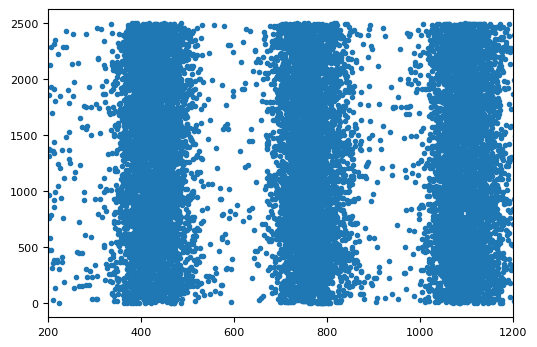

In [22]:
plt.rcParams['figure.figsize'] = [6, 4]
ts, evs = dSD['times'], dSD['senders']
plt.plot(ts, evs, '.')
plt.xlim(200., 1200.)

In [23]:
# run the simulation for all orientations
V1rates = network.simulate_all_orientations(a, mean_of_thalInputs = mean_of_TCinputs, 
                                            tuningAmps = tuningAmps, 
                                            phase_of_thalInputs = phase_of_inputs, 
                                            mean_of_inh = mean_of_inh)

simulation time -- 23.67778992652893 ms
stimulation degree: 0; mean firing rate: 5.784


simulation time -- 48.92459487915039 ms
stimulation degree: 15; mean firing rate: 5.709


simulation time -- 72.16584992408752 ms
stimulation degree: 30; mean firing rate: 5.213


simulation time -- 96.17724084854126 ms
stimulation degree: 45; mean firing rate: 5.526


simulation time -- 121.29106593132019 ms
stimulation degree: 60; mean firing rate: 6.057


simulation time -- 145.8679039478302 ms
stimulation degree: 75; mean firing rate: 5.770


simulation time -- 167.81882500648499 ms
stimulation degree: 90; mean firing rate: 5.256


simulation time -- 189.2387900352478 ms
stimulation degree: 105; mean firing rate: 5.014


simulation time -- 211.27073001861572 ms
stimulation degree: 120; mean firing rate: 5.337


simulation time -- 237.94586205482483 ms
stimulation degree: 135; mean firing rate: 5.805


simulation time -- 262.52989196777344 ms
stimulation degree: 150; mean firing rate: 5.589


si

In [24]:
# calculate input OSI and PO from the input amplitudes
inOSIs, inPOs = par.V1_OSI_PO(tuningAmps)
# calculate output OSI and PO from the output mean firing rates
OSIs, POs = par.V1_OSI_PO(V1rates)
print (np.mean(inOSIs), np.mean(OSIs))

0.16692028755201974 0.20016655916972992


__Plot out the input and output tuning curves in polar plot. Do they look similar?__

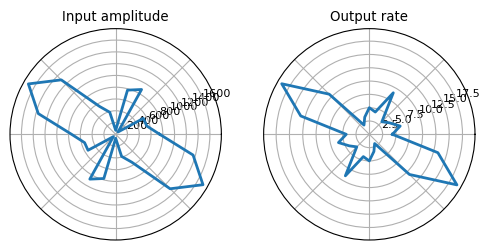

In [32]:
V1id = np.random.randint(low=0, high=par.NParams['N_ctx'], size=1)[0]

fig, axs = plt.subplots(1, 2, subplot_kw={'projection': 'polar'})

axs[0].set_title('Input amplitude')
par.plot_polar_curve(axs[0], tuningAmps[V1id])

axs[1].set_title('Output rate')
par.plot_polar_curve(axs[1], V1rates[V1id])

__Plot out the input PO vs. output PO of all V1 neurons.__

Text(0, 0.5, 'output PO [$^\\circ$]')

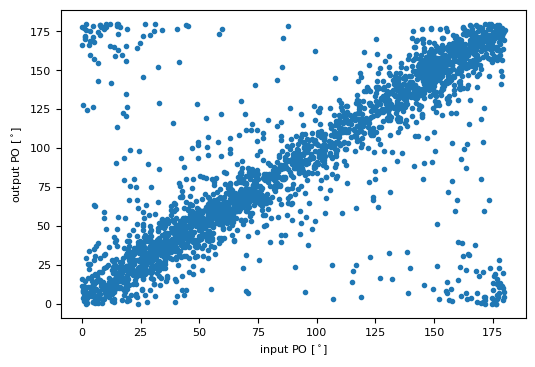

In [26]:
# plot out the input PO vs. output PO
plt.plot(inPOs, POs, '.')
plt.xlabel(r'input PO [$^\circ$]')
plt.ylabel(r'output PO [$^\circ$]')

__Plot out the input OSI vs. output OSI of all V1 neurons.__

Text(0, 0.5, 'output OSI')

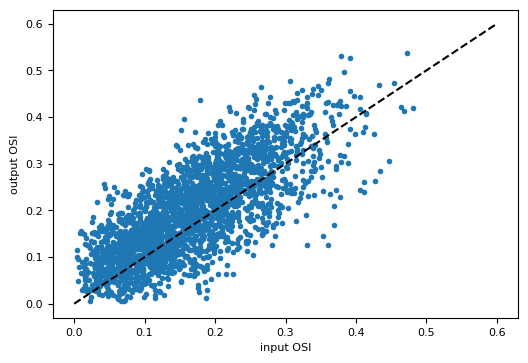

In [27]:
# plot out the input OSI vs. output OSI
plt.plot(inOSIs, OSIs, '.')
plt.plot((0., 0.6), (0., 0.6), 'k--')
plt.xlabel(r'input OSI')
plt.ylabel(r'output OSI')

## Finish!